### Useful Imports and Global Variables

**Numpy**
: NumPy is a Python library used for working with arrays. It also has functions for working in domain of linear algebra, fourier transform, and matrices. NumPy was created in 2005 by Travis Oliphant. It is an open source project and you can use it freely.

**Pandas**
: pandas is a software library written for the Python programming language for data manipulation and analysis. In particular, it offers data structures and operations for manipulating numerical tables and time series.

**Matplotlib**
: Matplotlib is a plotting library for the Python programming language and its numerical mathematics extension NumPy. It provides an object-oriented API for embedding plots into applications using general-purpose GUI toolkits like Tkinter, wxPython, Qt, or GTK.

**Scikit-Learn**
: Scikit-learn is a free software machine learning library for the Python programming language. It features various classification, regression and clustering algorithms including support vector machine.

**Tensorflow**
: TensorFlow is a free and open-source software library for machine learning and artificial intelligence. It can be used across a range of tasks but has a particular focus on training and inference of deep neural networks.

**OpenCV**
: OpenCV is a library of programming functions mainly aimed at real-time computer vision. Originally developed by Intel, it was later supported by Willow Garage then Itseez.

To Install these library, Type this in your terminal
`pip install numpy pandas matplotlib scikit-learn tensorflow opencv-python`

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras import models, layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
import cv2

N_EPOCHS = 100
path_to_dataset = 'CK+48'
LABELS = os.listdir(path_to_dataset)
checkpoint = 'checkpoint/model'

### Function: Load the images and One Hot Encode the labels

**One Hot Encoding**
: One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

In [19]:
def get_data(path_to_dataset='CK+48'):   
    dataX = []
    dataY = []
    for i in LABELS:
        files = os.listdir(path_to_dataset + '/' + i)
        for f in files:
            image = plt.imread(path_to_dataset + '/' + i + '/' + f)
            dataX.append(image)
            dataY.append(LABELS.index(i))
    dataX = np.array(dataX).reshape(-1, 48, 48, 1)
    dataY = np.array(dataY, dtype=int)

    labelizer = LabelBinarizer()
    labelizer.fit(range(dataY.max() + 1))
    dataY = labelizer.transform(dataY)
    return dataX, dataY

def remove_one_hot_encoding(data):
    new_data = []
    for d in data:
        new_data.append(np.argmax(d))
    return np.array(new_data)

### Function: Create and Train Model from the data

In [3]:
def create_and_train_model(dataX, dataY, N_EPOCHS=100, save=True, load_prev = True):
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), input_shape=(48, 48, 1), activation='elu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3,3)),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3, 3), activation='elu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3,3)),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3, 3), activation='elu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3,3)),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(128, activation='elu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(len(LABELS), activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    if load_prev:
        model.load_weights(checkpoint)
    if save:
        checkpoint_callback = ModelCheckpoint(
            checkpoint,
            monitor="accuracy",
            save_best_only=True,
            save_weights_only=True,
            mode="max",
        )
        hist = model.fit(trainX, trainY, epochs=N_EPOCHS, callbacks=[checkpoint_callback])
    else:
        hist = model.fit(trainX, trainY, epochs=N_EPOCHS)
    return model, hist

### Function: Show random images with their emotions

In [4]:
def get_label(k):
    return LABELS[np.argmax(k)]

def show_random_images(model, predictions, n=5):
    random_indexes = [random.randint(0, testX.shape[0]) for _ in range(n)]
    for i in random_indexes:
        prediction = model.predict(np.array([testX[i]]))
        plt.imshow(testX[i], cmap='gray')
        plt.ylabel("Predicted: {}".format(get_label(prediction[0])))
        plt.xlabel("True: {}".format(get_label(testY[i])))
        plt.show()

### Function: Predict the emotions of images in the directory

In [5]:
def show_images_emotions(directory = 'images/'):
    for i in os.listdir(directory):
        image = cv2.imread(directory + i, cv2.IMREAD_GRAYSCALE)
        image = image.reshape(48, 48, 1)
        prediction = model.predict(np.array([image]))
        plt.imshow(image, cmap='gray')
        plt.ylabel("Predicted: {}".format(get_label(prediction)))
        plt.show()

### Split the data into train and test part

In [6]:
dataX, dataY = get_data()

trainX, testX, trainY, testY = train_test_split(dataX, dataY, random_state=101)
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(735, 48, 48, 1) (735, 7) (246, 48, 48, 1) (246, 7)


### Show the first image of train data and it's emotion

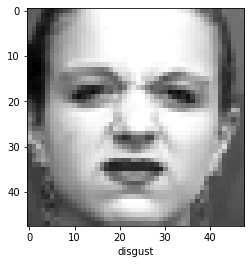

In [7]:
plt.imshow(trainX[0], cmap='gray')
plt.xlabel(get_label(trainY[0]))
plt.show()

### Create and Train the model and plot its graph

23/23 [==============================] - 4s 159ms/step - loss: 0.0319 - accuracy: 0.9905


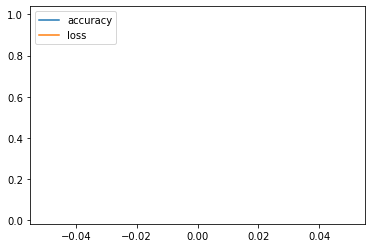

In [8]:
model, hist = create_and_train_model(trainX, trainY, N_EPOCHS=1)

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['loss'])
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

### Getting the accuracy of the model

In [9]:
loss, accuracy = model.evaluate(testX, testY)

print(f"Loss: {loss:.3f}\nAccuracy: {accuracy*100:.2f}%")

8/8 [==============================] - 0s 20ms/step - loss: 0.0054 - accuracy: 1.0000
Loss: 0.005
Accuracy: 100.00%


### Taking random images and showing them with predicted and real emotions

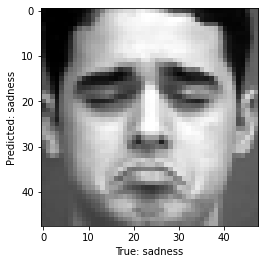

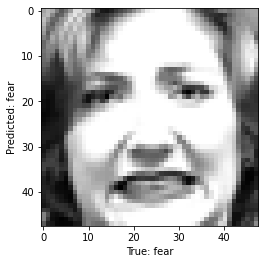

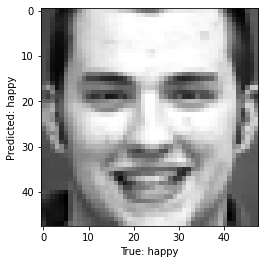

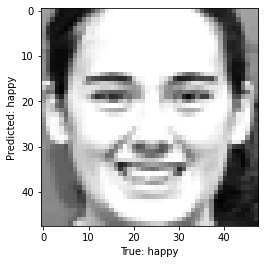

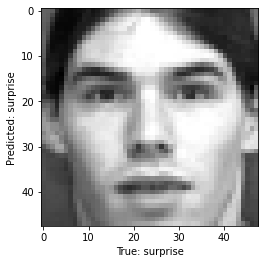

In [14]:
predictions = model.predict(trainX)
show_random_images(model, predictions)

### Predicting the Emotions of the images in the directory

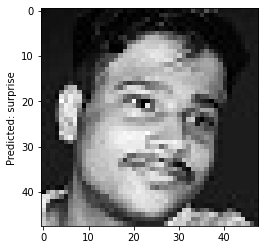

In [11]:
show_images_emotions()

### Visualizing the Model

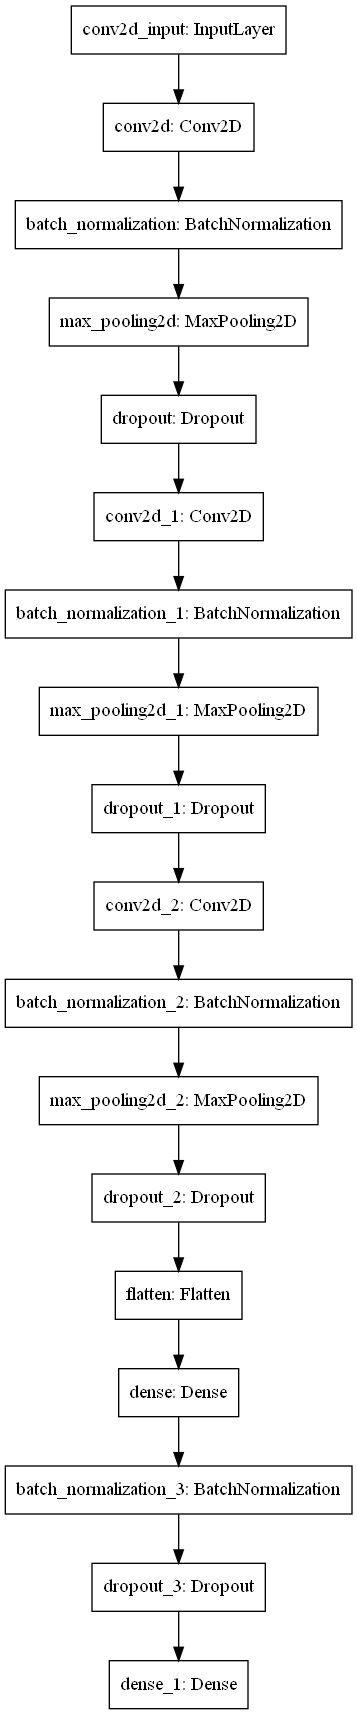

In [12]:
# !pip install pydot graphviz pydotplus
plot_model(model, to_file='model.png')

### Displaying Confusion Matrix

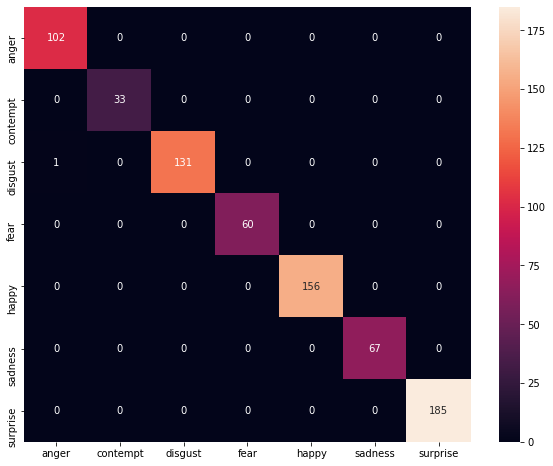

In [33]:
d = remove_one_hot_encoding(trainY)
p = remove_one_hot_encoding(predictions)
d, p = d.reshape(-1, 1), p.reshape(-1, 1)
con_mat = confusion_matrix(d, p)

plt.figure(figsize=(10, 8))
sns.heatmap(con_mat, annot=True, fmt='d', xticklabels=LABELS, yticklabels=LABELS)
plt.savefig('confusion_matrix.png')